In [13]:
from typing import *
import os
import argparse
import yaml
from PIL import Image
import numpy as np
import cv2 as cv
import torch
import torchvision
from facenet_pytorch import MTCNN
from tqdm import tqdm

from agnet.model import AGNet

from agnet.predict import Predictor

d:\Research Lab\computer vision\env\image\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
config = yaml.load(open("./agnet/predict_config.yaml",'r'))
FACE_MARGIN = config['model']['FACE_MARGIN']
FACE_PRESENT_THRESHOLD = config['model'].get("FACE_PRESENT_THRESHOLD",0.7)
device = torch.device("cpu")

mtcnn = MTCNN(image_size=config['data']['IMAGE_SIZE'], device=device)

GENDER_PREDICT_THRESHOLD = 0.5
gender_base_model = getattr(torchvision.models, config['model']['gender_base_model'])()
gender_dict = dict(
    _base_model=config['model']['gender_base_model'],
    output_dim=1,
    mlp_layer_name="",
    transfer_learning=False
)


In [15]:
def load_weights(model: torch.nn.Module, ck_path):
    params = torch.load(ck_path)
    print(model.load_state_dict(params['state_dict']))
    return model

In [16]:

gender_model = AGNet(gender_base_model,  **gender_dict)
gender_model = load_weights(gender_model, config['model']['gender_model_path'])

predictor = Predictor(
    mtcnn, 
    gender_model=gender_model, 
    device=device,
    image_size=config['data']['IMAGE_SIZE'],
    face_image_size=config['data']['FACE_IMAGE_SIZE'],
    FACE_PRESENT_THRESHOLD=FACE_PRESENT_THRESHOLD,
    GENDER_PREDICT_THRESHOLD=GENDER_PREDICT_THRESHOLD,
)

 resnet34
<All keys matched successfully>


In [20]:
image_path = "D:/WORK/freelance/agnet/dataset/utkface/part1/100_1_0_20170110183726390.jpg"

In [67]:
image_path = file_path

In [68]:
res = predictor.predict_byfile(image_path)

In [69]:
res

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x289>,
 'total_face_present': 1,
 'predict': [{'box': array([126.88154602050781, 54.62134552001953, 237.12985229492188,
          191.15176391601562], dtype=object),
   'face_logits': 0.9991934895515442,
   'gender': 'male',
   'gender_score': 0.9228393584489822}],
 'file_path': 'D:/WORK/freelance/agnet/dataset/utkface/part1/85_1_0_20170110183801752.jpg'}

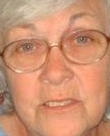

In [71]:
res['image'].crop(res['predict'][0]['box'])

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("test/eval/eval_utkface.csv")

In [3]:
df['p_gender'].value_counts()

0                      7742
1                      5471
0|0                     173
1|0                     100
0|0|0                    18
1|1                      15
0|1                      15
1|0|0                    10
0|0|1                     4
0|0|0|0                   4
1|0|1                     2
1|1|0                     2
1|0|0|0                   2
0|0|0|0|0                 1
1|0|0|0|0|0|0|0|0         1
1|0|0|0|0|0               1
1|1|0|0                   1
0|0|0|1                   1
1|0|0|1|1|0|0|0|0|0       1
0|0|1|0                   1
0|1|0                     1
Name: p_gender, dtype: int64

In [27]:
f_df = df[df['p_gender'].map(lambda x: "|" not in str(x))]

In [33]:
f_df.dropna(inplace=True)

In [28]:
from sklearn.metrics import classification_report

In [39]:
f_df = f_df[f_df['gender'].map(lambda x:x in [0,1])]

In [40]:
predicted = f_df['p_gender'].map(lambda x: int(x))

In [41]:
truth = f_df['gender'].map(lambda x: int(x))

In [66]:
file_path = f_df[predicted != truth].sample(1).iloc[0]['file_paths']
print(file_path)

D:/WORK/freelance/agnet/dataset/utkface/part1/85_1_0_20170110183801752.jpg


In [42]:
print(classification_report(truth, predicted))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      6707
           1       0.84      0.70      0.76      6505

    accuracy                           0.79     13212
   macro avg       0.79      0.79      0.78     13212
weighted avg       0.79      0.79      0.78     13212

